In [108]:
from keras.models import load_model
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np
import keras
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import os
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve

In [109]:
## List of models
print("\n".join([f for f in os.listdir("../../models/TopoDNN/topodnnmodels/")]))

topodnnmodel_standardize_pt
topodnnmodel_30
topodnnmodel_pt
topodnnmodel
topodnnmodel_pt0


In [110]:
#Can change to '', '_pt0','_pt', '_30', or '_standardize_pt'
mode = ''
#Load model
model = load_model("../../models/TopoDNN/topodnnmodels/topodnnmodel"+mode)
model.summary()


#Loading data
df_test = pd.read_pickle("../../datasets/topoprocessed/test.pkl")
labels = np.array(df_test.loc[:,df_test.columns == 'is_signal_new']).reshape(-1)
df_test = df_test.loc[:,df_test.columns != 'is_signal_new']

if mode == '_pt0':
    #Get rid of pt_0 column
    df_test = df_test.loc[:, df_test.columns != 'pt_0']
elif mode == '_pt':
    pt_cols = [col for col in df_test.columns if 'pt' in col]
    df_test = df_test.drop(pt_cols, axis=1)
elif mode == '_30':
    df_test = df_test.iloc[:,:30]
elif mode == '_standardize_pt':
    pt_cols = [col for col in df_test.columns if 'pt' in col]
    df_test[pt_cols] = (df_test[pt_cols] - df_test[pt_cols].mean())/df_test[pt_cols].std()


feats = np.array(df_test)
means = np.array(df_test.mean(0))
feat_names = list(df_test.columns)


print("Features shape: ", feats.shape)
print("Means shape: ", means.shape)
print("Results shape: ", labels.shape)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               27300     
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 102)               30702     
                                                                 
 activation_1 (Activation)   (None, 102)               0         
                                                                 
 dense_2 (Dense)             (None, 12)                1236      
                                                                 
 activation_2 (Activation)   (None, 12)                0         
                                                                 
 dense_3 (Dense)             (None, 6)                 7

In [111]:
for layer in model.layers:
    print(layer, layer.name)

<keras.layers.core.dense.Dense object at 0x7fa02c043f10> dense
<keras.layers.core.activation.Activation object at 0x7fa02c0430d0> activation
<keras.layers.core.dense.Dense object at 0x7fa02c043a00> dense_1
<keras.layers.core.activation.Activation object at 0x7fa02c0a5d60> activation_1
<keras.layers.core.dense.Dense object at 0x7fa02c0a5c70> dense_2
<keras.layers.core.activation.Activation object at 0x7fa02c0a5790> activation_2
<keras.layers.core.dense.Dense object at 0x7fa02c0a5250> dense_3
<keras.layers.core.activation.Activation object at 0x7fa02c085160> activation_3
<keras.layers.core.dense.Dense object at 0x7fa02c0856d0> dense_4
<keras.layers.core.activation.Activation object at 0x7fa02c085c10> activation_4


In [112]:
layer.name

'activation_4'

In [113]:
def NeuronFiringEvaluator(model, x):
    FiringEvaluator = []
    layer_tags = []
    for ii, layer in enumerate(model.layers):
        x = layer(x)
        if 'activation' in layer.name and ii < len(model.layers) - 1:
            FiringEvaluator.append(np.array(tf.math.reduce_sum(x, 0)))
            layer_tags.append("Layer " + str(len(FiringEvaluator)))
    return FiringEvaluator, layer_tags

In [117]:
def ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag='baseline', save=False):
    tag = 'baseline' if tag == ''else tag.strip('_')
    N_cols = len(FiringMatrix_0)
    N_rows = max([len(i) for i in FiringMatrix_0])
    Nnodes = 0
    for ii in range(len(FiringMatrix_0)):
        max_0 = FiringMatrix_0[ii].max()
        max_1 = FiringMatrix_1[ii].max()
        FiringMatrix_0[ii] = FiringMatrix_0[ii]/max_0
        FiringMatrix_1[ii] = FiringMatrix_1[ii]/max_1
        Nnodes += len(FiringMatrix_0[ii])
    for ii in range(N_cols):
        if len(FiringMatrix_0[ii]) < N_rows:
            FiringMatrix_0[ii] = np.append(FiringMatrix_0[ii], 
                                           np.ones(N_rows - len(FiringMatrix_0[ii]))*np.nan)
            FiringMatrix_1[ii] = np.append(FiringMatrix_1[ii], 
                                           np.ones(N_rows - len(FiringMatrix_1[ii]))*np.nan)
    
    FiringMatrix_0 = np.array(FiringMatrix_0)
    FiringMatrix_1 = np.array(FiringMatrix_1)

    print("Sparsity measure (RNA < 0.2) for background jets: ", np.sum(FiringMatrix_0 < 0.2)/Nnodes)
    print("Sparsity measure (RNA < 0.2) for signal jets: ", np.sum(FiringMatrix_1 < 0.2)/Nnodes)
    ## The relative node firing rates for class 0 are multiplied by a factor of -1
    ## to represent the NAPs of two classes side by side for a visual comparison
    weights = np.append(-1*FiringMatrix_0.reshape(-1), FiringMatrix_1.reshape(-1)) 
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.25
    x = np.append(x, np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.75)
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    y = np.append(y,y)
    
    fig, axes = plt.subplots(1,1,figsize=(20,20))
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(0,N_cols+0.25,0.5), np.arange(N_rows+1)],
                   weights = weights, cmap = 'bwr', cmin = -1, cmax = 1)
    axes.set_facecolor('grey')

    fig.colorbar(im, ax=axes)
    axes.set_xlabel('Network Activation Layers', fontsize = 20)
    axes.set_ylabel('Node in hidden layer', fontsize = 20)
    axes.set_xticks(np.arange(N_cols) + 0.5) 
    axes.set_xticklabels(layer_tags, rotation='vertical',  fontsize=20)
    axes.tick_params(axis='both', which='major', labelsize=20)
    if save:
        plt.savefig("figures/NAP_TopoDNN_{}.png".format(tag))
    plt.show()
    
    
    fig, axes = plt.subplots(1,1,figsize=(20,20))
    weights = np.abs(FiringMatrix_1.reshape(-1) - FiringMatrix_0.reshape(-1))
    x = np.array([np.arange(N_cols)]*N_rows).T.reshape(-1) + 0.5
    y = np.array([np.arange(N_rows)]*N_cols).reshape(-1) + 0.5
    _,_,_,im = axes.hist2d(x,y,
                   bins=[np.arange(N_cols+1), np.arange(N_rows+1)],
                   weights = weights, cmap = 'Reds')

    fig.colorbar(im, ax=axes)
    axes.set_facecolor('grey')
    axes.set_xlabel('Network Activation Layers', fontsize=20)
    axes.set_ylabel('Node in hidden layer', fontsize=20)
    axes.set_xticks(np.arange(N_cols) + 0.5)
    axes.set_xticklabels(layer_tags, rotation='vertical', fontsize=20)
    axes.tick_params(axis='both', which='major', labelsize=20)
    if save:
        plt.savefig("figures/dNAP_TopoDNN_{}.png".format(tag))
    plt.show()

In [118]:
FiringMatrix_0, layer_tags = NeuronFiringEvaluator(model, feats[labels==0])
FiringMatrix_1, layer_tags = NeuronFiringEvaluator(model, feats[labels==1])

Sparsity measure (RNA < 0.2) for background jets:  0.8571428571428571
Sparsity measure (RNA < 0.2) for signal jets:  0.7571428571428571


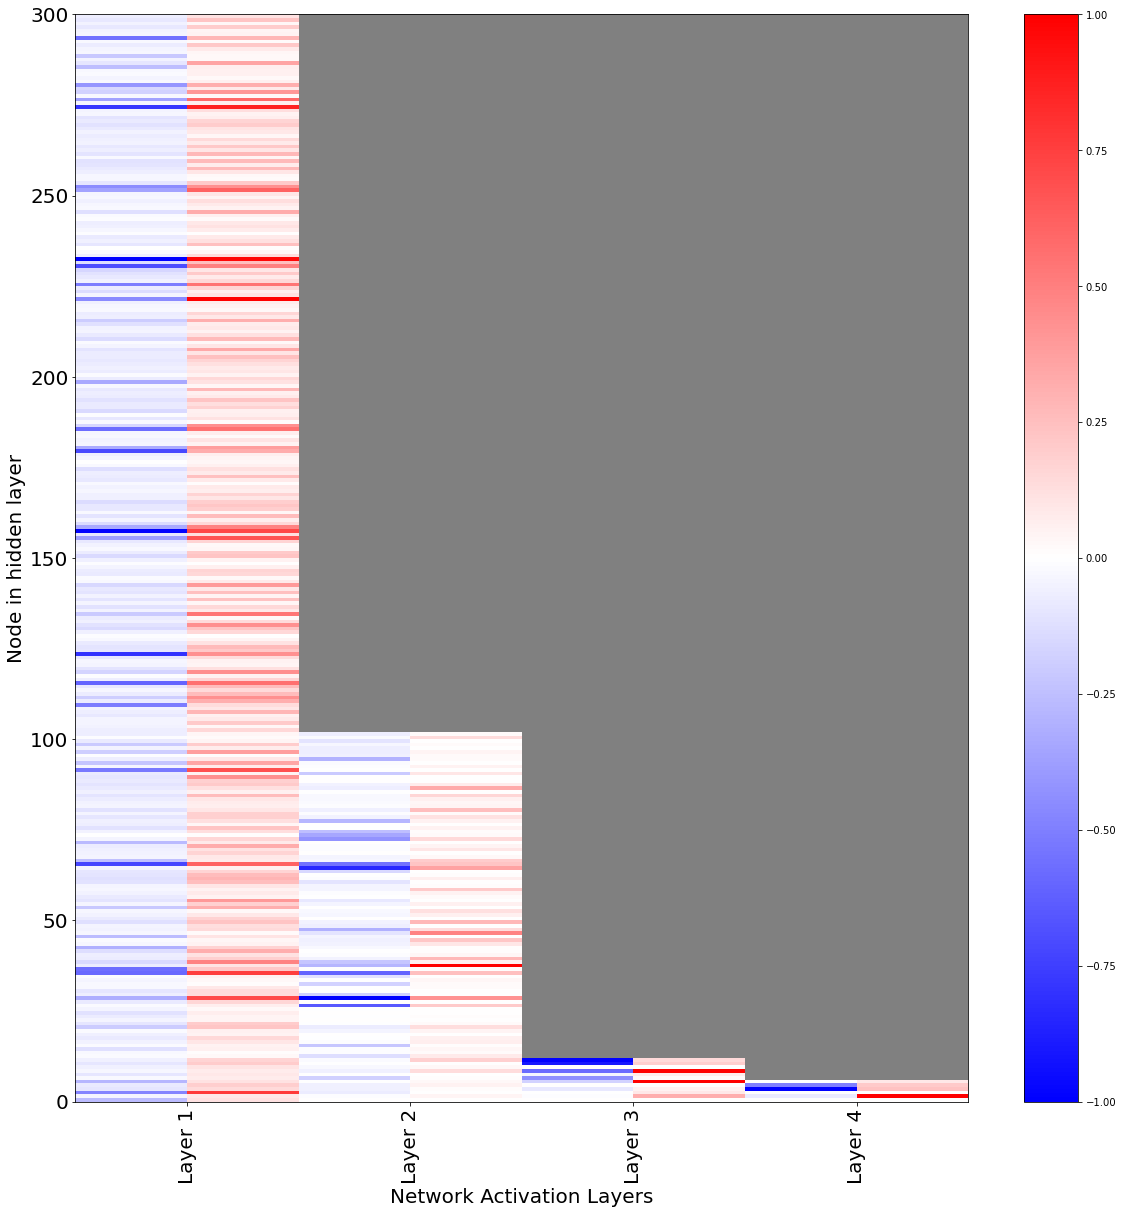

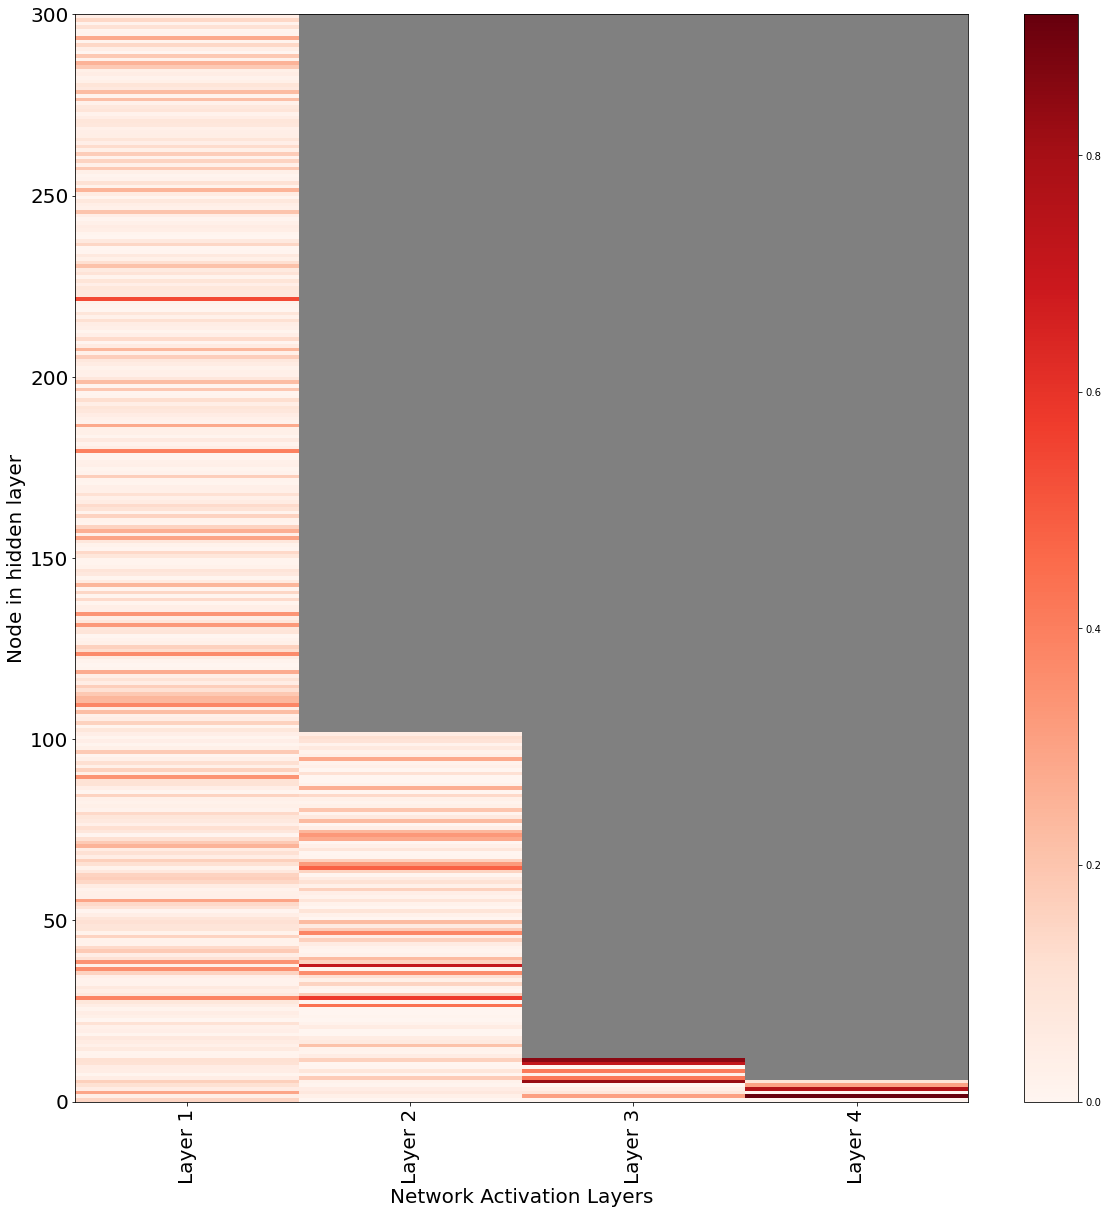

In [119]:
ActivationMapPlotter(FiringMatrix_0, FiringMatrix_1, layer_tags, tag=mode, save=True)